In [21]:
import hopsworks
import joblib
import os

import pandas as pd
import numpy as np
from matplotlib import pyplot
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [22]:
project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://pocs.cloud.hopsworks.ai/p/125
Connected. Call `.close()` to terminate connection gracefully.


In [25]:
feature_view = fs.get_feature_view("fraud_model_fv", 1)

In [26]:
X_train, X_test, y_train, y_test = feature_view.get_train_test_split(1)

In [27]:
X_train

,amount,category,time_delta_t_minus_1,loc_delta_t_minus_1,outside_city,cc_provider,cc_type,age,cc_expiration_days,count,min_amount,max_amount,mean
0,88.05,0,5.208333,0.000108,1,0,0,90.780822,568,1,2.47,2.47,2.47
1,66.52,1,4.123866,0.247789,1,1,0,37.315068,660,1,66.52,66.52,66.52
2,83.48,1,2.858889,0.138663,1,1,1,34.569863,1511,1,83.48,83.48,83.48
3,97.17,0,1.001528,0.217713,1,0,0,19.627397,-71,1,77.90,77.90,77.90
4,100.77,1,0.702928,0.426111,1,1,1,94.369863,476,1,100.77,100.77,100.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69500,92.63,0,0.019456,0.074383,1,0,0,67.084932,1206,1,94.01,94.01,94.01
69501,46.71,2,16.589074,0.310116,1,1,1,27.243836,568,1,46.71,46.71,46.71
69502,8.56,2,0.617940,0.452488,1,0,0,99.939726,1419,1,8.56,8.56,8.56
69503,22.76,1,4.959769,0.250950,1,0,0,40.863014,295,1,22.76,22.76,22.76


In [28]:
# Create an instance of the XGBClassifier
clf = xgb.XGBClassifier()

# Fit the classifier on the training data
clf.fit(X_train.values, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [29]:
# Predict the training data using the trained classifier
y_pred_train = clf.predict(X_train.values)

# Predict the test data using the trained classifier
y_pred_test = clf.predict(X_test.values)

In [30]:
# Compute f1 score
metrics = {
    "f1_score": f1_score(y_test, y_pred_test, average='macro')
}
metrics

{'f1_score': 0.8999102495063723}

In [31]:
# Generate the confusion matrix using the true labels (y_test) and predicted labels (y_pred_test)
results = confusion_matrix(y_test, y_pred_test)

# Print the confusion matrix
print(results)

[[2785    0]
 [   1    2]]


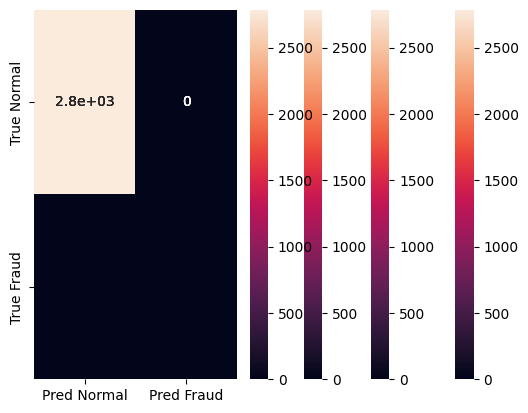

In [32]:
# Create a DataFrame from the confusion matrix results with appropriate labels
df_cm = pd.DataFrame(
    results, 
    ['True Normal', 'True Fraud'],
    ['Pred Normal', 'Pred Fraud'],
)

# Create a heatmap using seaborn with annotations
cm = sns.heatmap(df_cm, annot=True)

# Get the figure from the heatmap and display it
fig = cm.get_figure()
fig

In [33]:
# Register the model with the model registry
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Define the input schema using the values of X_train
input_schema = Schema(X_train.values)

# Define the output schema using y_train
output_schema = Schema(y_train)

# Create a ModelSchema object specifying the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Convert the model schema to a dictionary for further inspection or serialization
model_schema.to_dict()

{'input_schema': {'tensor_schema': {'shape': '(69505, 13)',
   'type': 'float64'}},
 'output_schema': {'columnar_schema': [{'name': 'fraud_label',
    'type': 'int64'}]}}

In [34]:
# Specify the directory where the model will be saved
model_dir = "fraud_model"

# Check if the directory exists, and create it if it doesn't
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

# Save the trained XGBoost model using joblib
joblib.dump(clf, model_dir + '/xgboost_fraud_model.pkl')

# Save the confusion matrix heatmap as an image in the model directory
images_dir = f"{model_dir}/images"
if not os.path.isdir(images_dir):
    os.mkdir(images_dir)
fig.savefig(images_dir + "/confusion_matrix.png")

In [35]:
# Get the model registry
mr = project.get_model_registry()

# Create a new model in the model registry
fraud_model = mr.python.create_model(
    name="xgboost_fraud_model",           # Name for the model
    metrics=metrics,                      # Metrics used for evaluation
    model_schema=model_schema,            # Schema defining the model's input and output
    input_example=X_train.sample(),       # Example input data for reference
    description="Fraud Predictor",        # Description of the model
)

# Save the model to the specified directory
fraud_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://pocs.cloud.hopsworks.ai/p/125/models/xgboost_fraud_model/1


Model(name: 'xgboost_fraud_model', version: 1)